In [1]:
config_action12 = {
    "models":[
        {"type":"lg", "params":{}}
    ],
    "time_splits":[
        {"type":"action","action_date":"2016-01-30","train_timedelta":"1460D","test_window_size":"365D"}
     ],
    "feature_sets":[
        {"name":"all_feats","list":["demographics","dynamic","system","historical"]}
    ],
    "data_subsets":[
        {"type":"month_thresh","cutoff":12}
    ],
    "cutoffs":[
        {"type":"number", "value":50},
        {"type":"number", "value":100},
        {"type":"number", "value":1000}
    ],
    "labels":[
        {"ltu_length":12}
    ],
    "historical":[
        {"limit":"1095D"}
    ]    
}

In [193]:
config_action6 = {
    "models":[
        {"type":"lg", "params":{}}
    ],
    "time_splits":[
        {"type":"action","action_date":"2015-10-30","train_timedelta":"1460D","test_window_size":"365D"}
     ],
    "feature_sets":[
        {"name":"all_feats","list":["demographics","dynamic","system","historical"]}
    ],
    "data_subsets":[
        {"type":"month_thresh","cutoff":6}
    ],
    "cutoffs":[
        {"type":"number", "value":50},
        {"type":"number", "value":100},
        {"type":"number", "value":1000}
    ],
    "labels":[
        {"ltu_length":12}
    ],
    "historical":[
        {"limit":"1095D"}
    ]    
}

In [194]:
config_appRF = {
    "models":[
        {"type":"rf", "params":{}}
    ],
    "time_splits":[
        {"type":"date","action_date":"2015-12-30","train_timedelta":"1460D","test_window_size":"365D"}
     ],
    "feature_sets":[
        {"name":"all_feats","list":["demographics","system","historical"]}
    ],
    "data_subsets":[
        {"type":"month_thresh","cutoff":12}
    ],
    "cutoffs":[
        {"type":"number", "value":50},
        {"type":"number", "value":100},
        {"type":"number", "value":1000}
    ],
    "labels":[
        {"ltu_length":12}
    ],
    "historical":[
        {"limit":"1095D"}
    ]    
}

In [195]:
config = config_action6

In [196]:
import json
import sys
import pandas as pd
sys.path.append("../../")
from utils import model_utils
from utils import db_utils
from utils import feature_utils
from utils import iefp_data_utils
from utils import train_test_utils
import os
import datetime as dt

In [197]:
conn = db_utils.connect_to_db()
apps,movs = iefp_data_utils.get_clean_data(conn)  

In [198]:
system_info = feature_utils.generate_system_info(apps)
historical_limit = config['historical'][0]['limit']
historical_info = feature_utils.generate_historical(apps, historical_limit)

In [199]:
for time_split in config['time_splits']:
    model_id_counter = 1
    
    split_type = time_split['type']
    action_date = pd.to_datetime(time_split['action_date'])
    train_timedelta = pd.Timedelta(time_split['train_timedelta'])
    test_window_size = pd.Timedelta(time_split['test_window_size'])
    train_st_date = action_date - train_timedelta

In [200]:
ltu_length = config['labels'][0]['ltu_length']
if split_type == "action":
    train_apps,test_apps,train_movs,test_movs = train_test_utils.split_train_test_apps(apps,movs,action_date,train_st_date,ltu_length) 
    print "Generating LTU Labels"
    train_labels = train_test_utils.get_ltu_label_on_date(train_apps,movs,action_date,ltu_length)
    test_labels = train_test_utils.get_ltu_label_on_date(test_apps,movs,action_date + test_window_size,ltu_length)
    print "Extending data"
    extended_train = train_test_utils.extend_data(train_apps,movs,train_labels,action_date,pd.Timedelta('30D'))
    extended_test = train_test_utils.extend_data(test_apps,movs,test_labels,action_date,None)
elif split_type == "date":
    train_apps,test_apps,train_movs,test_movs = train_test_utils.split_train_test_date(apps,movs,action_date,train_st_date,test_window_size)
    train_labels = train_test_utils.get_ltu_label_on_date(train_apps,movs,action_date,ltu_length)
    #use end time as today. Which applications we use for testing is determined by the window, but we can check the outcome of the application at any time after. 
    test_labels = train_test_utils.get_ltu_label_on_date(test_apps,movs,dt.date.today(),ltu_length)
    extended_train = train_test_utils.extend_data(train_apps,movs,train_labels,action_date,None)
    extended_test = train_test_utils.extend_data(test_apps,movs,test_labels,action_date,None)

Generating LTU Labels
Generating LTU/Non-LTU labels
Generating LTU/Non-LTU labels
Extending data


In [201]:
for feature_set in config['feature_sets']:
    feature_set_list = feature_set['list']
    if split_type=="date" and "dynamic" in feature_set_list:
        print "Warning: not possible to use dynamic features when predicting on application date"
        continue
    print "Generating Features"
    pd.options.mode.chained_assignment = None #turns off warning for chained assignment
    train_matrix = feature_utils.generate_matrix(extended_train,train_apps,train_movs,feature_set_list,system_info,historical_info)
    test_matrix = feature_utils.generate_matrix(extended_test,test_apps,test_movs,feature_set_list, system_info, historical_info)
    
    #TEST ONLY ON THOSE LESS THAN 6 mo in
    test_matrix = test_matrix[test_matrix['months_so_far']<=6.0]
    
    #remove columns that do not appear in both train and test matrixes (e.g., infrequent categorical variables)
    in_both=list(set(train_matrix.columns)-set(test_matrix.columns))
    in_both=in_both+list(set(test_matrix.columns)-set(train_matrix.columns))
    for k in in_both: 
        if k in train_matrix:
            del train_matrix[k]
        if k in test_matrix:
            del test_matrix[k]

Generating Features
Generating matrix base
Adding demographic features
Adding system features
Adding historical features
Adding dynamic features
Generating matrix base
Adding demographic features
Adding system features
Adding historical features
Adding dynamic features


In [202]:
for model in config['models']:
    model_params = model['params']
    model_params_index = str(config['models'].index(model))
    model_id = "selected_model"#str(model_id_counter)+'_'+model['type']+'_paramset'+model_params_index+'_'+feature_set['name']+'_'+config_filepath
    train_test_id = "selected_train_test"#str(train_test_id_counter)+'_'+model_utils.get_time()

    print "Training Model"
    model_obj = model_utils.train_model(model['type'],train_matrix,model_params)

    print "Testing Model"
    model_results = model_utils.test_model(model['type'],model_obj,test_matrix,model_id)
    print "Evaluating Model Performance"
    model_res_apps = model_utils.prepare_model_results_for_analysis(model_results,apps,model_id)
    test_subsets = model_utils.build_test_eval_subset_df(config['data_subsets'],model_res_apps)
    model_performance = model_utils.evaluate_model(model_res_apps, config['cutoffs'], test_subsets, model_id,train_test_id)

    print "Appending performance metrics to db"
    db_utils.write_table(model_performance,conn, 'model_output', 'performances', if_exists='append')

    print "Getting config details"
    train_total = len(train_matrix)
    train_proportion_ltu = train_matrix.ltu.mean()
    test_total = len(test_matrix)
    test_proportion_ltu = test_matrix.ltu.mean()
    features_string = " ".join(str(x) for x in feature_set_list)
    params_string = '_'.join('{}{}'.format(key, val) for key, val in model_params.items())

Training Model
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.344110495701
            Iterations: 525
            Function evaluations: 533
            Gradient evaluations: 525
Testing Model
Evaluating Model Performance
Calculating performance metrics for model: selected_model, train_test_split: selected_train_test
Appending performance metrics to db
Getting config details


# Testing RF at application time

In [100]:
import sklearn
import numpy as np
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [167]:
proba_results_Apr2016 = model_results.copy()
proba_results_Apr2016.head()

,,ltu,selected_model
application_id,ref_date,,
105939,2016-04-30,True,0.469145
106001,2016-04-30,True,0.697364
118083,2016-04-30,True,0.538328
105987,2016-04-30,False,0.675519
105993,2016-04-30,False,0.698547


In [14]:
proba_results['prediction'] = proba_results['selected_model']>=0.5

In [20]:
# for 
sklearn.metrics.confusion_matrix(y_true = proba_results['ltu'], y_pred = proba_results['prediction'])

array([[2157,  846],
       [1214, 2675]])

In [21]:
sklearn.metrics.precision_score(y_true = proba_results['ltu'], y_pred = proba_results['prediction'])

0.75972735018460669

In [149]:
model_config = pd.DataFrame({'model_id':model_id,'model_type':model['type'],'params':params_string, 'feature_set':features_string, "experiment":"no_experiment"}, index=[0])
model_config = model_config.reindex(columns=['model_id','model_type','params','feature_set','experiment'])

train_test_config = pd.DataFrame({'model_id':model_id, 'train_test_id':train_test_id,'split_type':split_type, 'action_date':action_date,'train_timedelta': time_split['train_timedelta'], 'train_total':train_total,'train_proportion_ltu':train_proportion_ltu,'test_total':test_total,'test_proportion_ltu':test_proportion_ltu}, index=[0])
train_test_config = train_test_config.reindex(columns=['model_id', 'train_test_id', 'split_type','action_date','train_timedelta','train_total','train_proportion_ltu','test_total','test_proportion_ltu'])

print "Getting feature importances"
feature_importance = model_utils.get_feature_importances(model_obj, model['type'], model_id, train_test_id, train_matrix, top_n=10)

Getting feature importances


/opt/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:1029: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/opt/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [ ]:
model_performance[model_performance['metric']=='precision']

In [ ]:
#test set details for threshold 6months
test_matrix_6mo = test_matrix[test_matrix['months_so_far']<=6.0]
print len(test_matrix_6mo)
print test_matrix_6mo.ltu.mean()

In [ ]:
model_obj.summary()

In [ ]:
pd.DataFrame(model_obj.pvalues)

In [ ]:
def summary_to_df(model_object):
    coefs = pd.DataFrame(model_object.params)
    coefs.columns = ['coefs']
    pvals = pd.DataFrame(model_object.pvalues)
    pvals.columns = ['p_values']
    df = pd.merge(coefs, pvals,left_index=True, right_index=True)
    return df

importances = summary_to_df(model_obj)

In [ ]:
importances.sort_values(by=['p_values'])

# Plotting precision curve

In [212]:
proba_results_Oct2015 = model_results.copy()
proba_results_Oct2015.head()

,,ltu,selected_model
application_id,ref_date,,
99423,2015-10-30,True,0.818494
99390,2015-10-30,False,0.668047
99391,2015-10-30,False,0.538915
99400,2015-10-30,True,0.741081
99422,2015-10-30,True,0.767593


In [213]:
print proba_results_Oct2015.ltu.mean()
print proba_results_Jan2016.ltu.mean()
print proba_results_Apr2016.ltu.mean()

0.449764681809
0.428816466552
0.431005818786


In [214]:
print train_test_config

         model_id        train_test_id split_type action_date train_timedelta  \
0  selected_model  selected_train_test     action  2016-04-30           1460D   

   train_total  train_proportion_ltu  test_total  test_proportion_ltu  
0       459473              0.681128        6899             0.547761  


In [257]:
def plot_precision(proba_results):
    predictions = proba_results.sort_values(by='selected_model', ascending = False)
    precision_list = []
    x_ticks = np.arange(50,1050,50)
    
    for k in x_ticks:
        proba_results['prediction'] = [1]*k+[0]*(len(predictions)-k)
        prec = sklearn.metrics.precision_score(y_true = proba_results['ltu'], y_pred = proba_results['prediction'])
        precision_list.append(prec)
    precision_df = pd.DataFrame(precision_list, index = x_ticks)
    precision_df.columns = ['Oct_2015_precision']
    
    baseline = proba_results['ltu'].mean()
    baseline_df = pd.DataFrame([baseline]*len(x_ticks), index = x_ticks)
    baseline_df.columns = ['Oct_2015_baseline']
    
    return precision_df, baseline_df

In [258]:
precOct, baseOct = plot_precision(proba_results_Oct2015)
precJan, baseJan = plot_precision(proba_results_Jan2016)
precApr, baseApr = plot_precision(proba_results_Apr2016)

In [259]:
baseBlended = (baseOct + baseJan + baseApr)/3

In [261]:
from matplotlib.pyplot import *

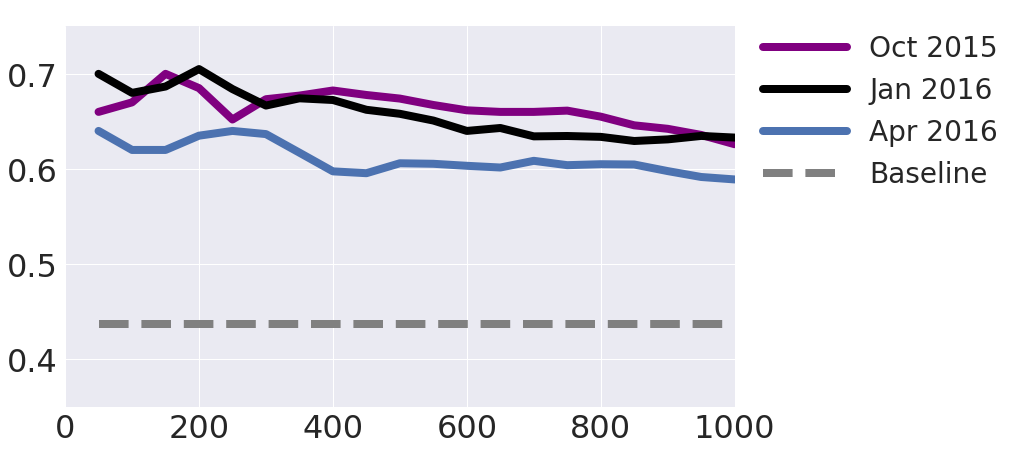

In [349]:
sns.set(font='sans-serif', font_scale=4)
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

plt.figure(figsize=(12,7))
ax1 = plt.subplot(111)
ax1.plot(precOct, linewidth=8.0, label = 'Oct 2015', color = 'purple')
ax1.plot(precJan, linewidth=8.0, label = 'Jan 2016', color = 'black')
ax1.plot(precApr, linewidth=8.0, label = 'Apr 2016')
ax1.plot(baseBlended, linewidth=8.0, linestyle='--', color='gray', label = 'Baseline')

ax1.set_xlabel("\nCutoff value: Number of prioritized individuals")
ax1.set_ylabel("Precision\n", fontname='Arial')

plt.xlabel("\nCutoff value: Number of prioritized individuals", fontname='Arial')

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels,frameon=False,borderpad=1,fontsize=28,\
           handlelength=3, loc=(1,.5))

ax1.set_ylim(0.35,0.75)
ax1.set_xlim(0,1000)
ax1.tick_params(axis='both', which='major', labelsize=32)

ax1.xaxis.label.set_visible(False)
ax1.yaxis.label.set_visible(False)

In [275]:
#baseline is between 43-45% depending on action date, we put a blended baseline of 

In [267]:
# dataframes for thinkcell graphs

In [265]:
combined_prec = pd.merge(pd.merge(pd.merge(precOct, precJan, left_index=True,right_index=True), precApr, left_index=True, right_index=True),\
                         baseBlended, left_index=True, right_index=True)
combined_prec.columns = ['Oct_2016', 'Jan_2016', 'Apr_2016', 'blended_baseline']

In [266]:
combined_prec.transpose()

,50,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000
Oct_2016,0.660000,0.670000,0.700000,0.685000,0.652000,0.673333,0.677143,0.682500,0.677778,0.674000,0.667273,0.661667,0.660000,0.660000,0.661333,0.655000,0.645882,0.642222,0.635789,0.626000
Jan_2016,0.700000,0.680000,0.686667,0.705000,0.684000,0.666667,0.674286,0.672500,0.662222,0.658000,0.650909,0.640000,0.643077,0.634286,0.634667,0.633750,0.629412,0.631111,0.634737,0.633000
Apr_2016,0.640000,0.620000,0.620000,0.635000,0.640000,0.636667,0.617143,0.597500,0.595556,0.606000,0.605455,0.603333,0.601538,0.608571,0.604000,0.605000,0.604706,0.597778,0.591579,0.589000
blended_baseline,0.436529,0.436529,0.436529,0.436529,0.436529,0.436529,0.436529,0.436529,0.436529,0.436529,0.436529,0.436529,0.436529,0.436529,0.436529,0.436529,0.436529,0.436529,0.436529,0.436529
